# New York Crime Statistics

### Goal: Create a regression model to predict Property Crime based on New York Crime data.

Use feature engineering to create a robust predictive model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import string
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

%matplotlib inline

In [2]:
crime_df = pd.read_csv('NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013 - 13tbl8ny.csv')

In [3]:
crime_df.head(5)

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,"1,861",0,0,NaN,0,0,0,12,2,10,0,0.0
1,Addison Town and Village,"2,577",3,0,NaN,0,0,3,24,3,20,1,0.0
2,Akron Village,"2,846",3,0,NaN,0,0,3,16,1,15,0,0.0
3,Albany,"97,956",791,8,NaN,30,227,526,"4,090",705,"3,243",142,NaN
4,Albion Village,"6,388",23,0,NaN,3,4,16,223,53,165,5,NaN


What might be good features? Let's try all of them and see how they look. But let's still make a new, clean dataframe because there are a lot of issues with the original. Note that "Violent Crime" is just the sum of Murder, Rape, Robbery, and Aggravated Assault, so let's exclude it from the analysis.

In [4]:
crime_clean = pd.DataFrame()
crime_clean['City'] = crime_df['City']

In [5]:
# Some columns are in an unfortunate format. Need to remove punctuation and convert to numeric.

translator = str.maketrans('', '', string.punctuation)
crime_clean['Population'] = [num.translate(translator) for num in crime_df['Population']]
crime_clean['Population'] = pd.to_numeric(crime_clean['Population'])

crime_clean['Robbery'] = [num.translate(translator) for num in crime_df['Robbery']]
crime_clean['Robbery'] = pd.to_numeric(crime_clean['Robbery'])

In [6]:
crime_clean['Murder'] = crime_df['Murder and\nnonnegligent\nmanslaughter']

In [7]:
crime_df['Rape\n(revised\ndefinition)1'].dropna()

Series([], Name: Rape\n(revised\ndefinition)1, dtype: float64)

Well, this is a whole row of NAN. Not that helpful.

In [8]:
crime_clean['Rape'] = [num.translate(translator) for num in crime_df['Rape\n(legacy\ndefinition)2']]
crime_clean['Rape'] = pd.to_numeric(crime_clean['Rape'])

crime_clean['Assault'] = [num.translate(translator) for num in crime_df['Aggravated\nassault']]
crime_clean['Assault'] = pd.to_numeric(crime_clean['Assault'])

crime_clean['Burglary'] = [num.translate(translator) for num in crime_df['Burglary']]
crime_clean['Burglary'] = pd.to_numeric(crime_clean['Burglary'])

crime_clean['Larceny'] = [num.translate(translator) for num in crime_df['Larceny-\ntheft']]
crime_clean['Larceny'] = pd.to_numeric(crime_clean['Larceny'])

crime_clean['MVTheft'] = [num.translate(translator) for num in crime_df['Motor\nvehicle\ntheft']]
crime_clean['MVTheft'] = pd.to_numeric(crime_clean['MVTheft'])

crime_clean['PropertyCrime'] = [num.translate(translator) for num in crime_df['Property\ncrime']]
crime_clean['PropertyCrime'] = pd.to_numeric(crime_clean['PropertyCrime'])

In [9]:
crime_clean.head(5)

,City,Population,Robbery,Murder,Rape,Assault,Burglary,Larceny,MVTheft,PropertyCrime
0,Adams Village,1861,0,0,0,0,2,10,0,12
1,Addison Town and Village,2577,0,0,0,3,3,20,1,24
2,Akron Village,2846,0,0,0,3,1,15,0,16
3,Albany,97956,227,8,30,526,705,3243,142,4090
4,Albion Village,6388,4,0,3,16,53,165,5,223


An issue: It appears that "Property Crime" (our target) is simply the sum of Burglary, Larceny, MVTheft, and Arson (excluded). It seems like it would be silly to build a predictive model that just summed three of the variables, so let's see if we can predict it based on the other variables instead.

In [10]:
crime_clean['Population'].sort_values(ascending=False).head(3)

216    8396126
35      258789
272     210562
Name: Population, dtype: int64

Another issue: NYC is a huge outlier. Let's just do the analysis without it. 

In [11]:
crime_nyc = crime_clean.drop(216)

/Users/maxcalabro/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


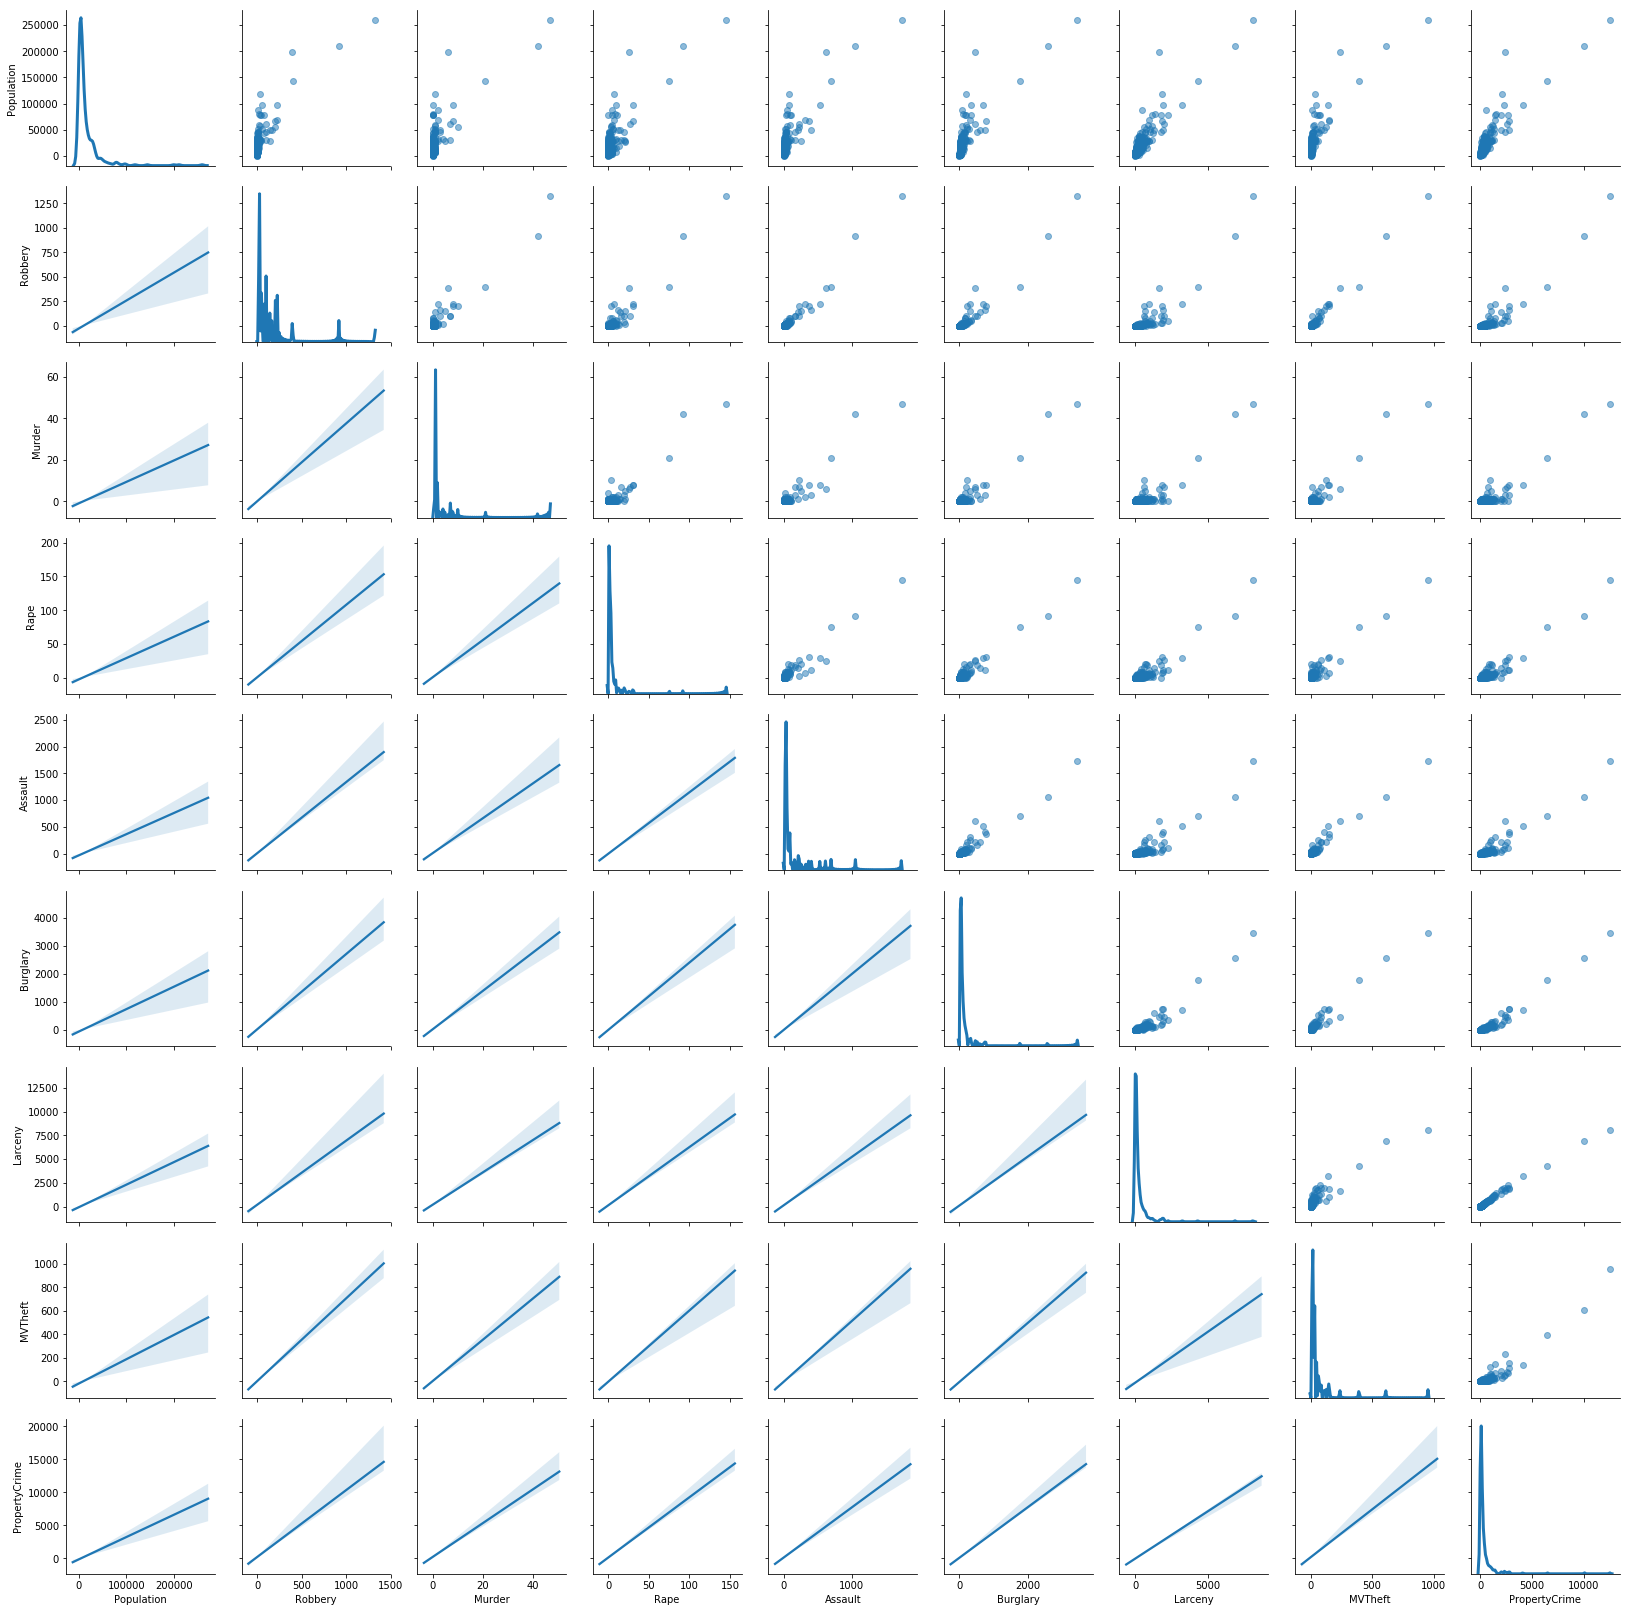

In [12]:
g = sns.PairGrid(crime_nyc.loc[:, 'Population':], diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot, lw=3)

plt.show()

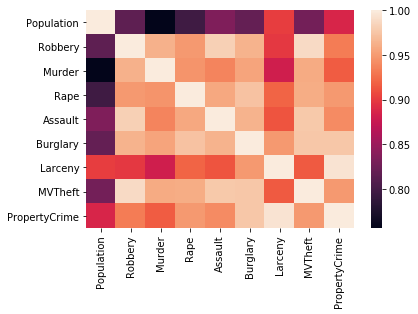

In [13]:
corrmat = crime_nyc.loc[:, 'Population':].corr()
sns.heatmap(corrmat)
plt.show()

So, everything has high correlation. Population is the lowest, around 0.75 with most things, but still 0.90 with Property Crime. This could cause some issues. Let's see what happens if we run our regression.

In [14]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = crime_nyc['PropertyCrime'].values.reshape(-1, 1)
X = crime_nyc.loc[:,'Population':'MVTheft']
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[  3.02429928e-17  -2.92582014e-15   9.83826968e-15   2.99749398e-15
   -6.97317069e-16   1.00000000e+00   1.00000000e+00   1.00000000e+00]]

Intercept: 
 [ -5.11590770e-13]

R-squared:
1.0


This is the problem I expected: it is simply adding the values from the last three variables. Let's exclude them from the analysis, as I assume that's not what we're trying to do here.

In [15]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = crime_nyc['PropertyCrime'].values.reshape(-1, 1)
X = crime_nyc.loc[:,'Population':'Assault']
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[  1.35211120e-02  -9.50319957e-01   5.66809439e+01   4.50251375e+01
    7.53545902e-01]]

Intercept: 
 [ 9.48025988]

R-squared:
0.950982619239


Better! This translates into:
PropertyCrime = (.014\*Population) - (0.95\*Robbery) + (57\*Murder) + (45\*Rape) + (.75\*Assault) + 9.5

With an R-squared value of 0.95, it doesn't seem like feature engineering would be worthwhile. If anything, correlations are already too high with this dataset, and trying to capture more information doesn't make sense. Let's check out the residuals to see if we're doing okay.

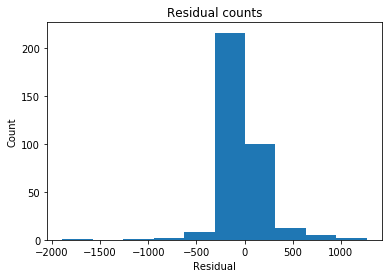

In [16]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = crime_nyc['PropertyCrime']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

This is a fairly normal distribution for the residual counts. Let's check out homoscedasticity. 

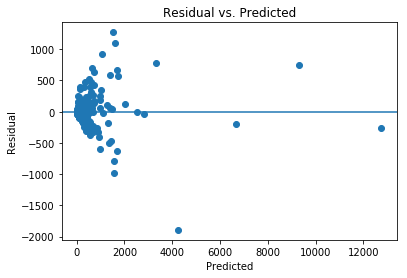

In [17]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

So, the model does better for small values and has more variance for larger values. This makes sense, partly because there are so few large values in the dataset. It's trained primarily on small values, and fits those well. It's impressive that it does as well as it does for some of the larger values.

Another factor here is that a lot of the small towns have values of zero for Rape and Murder, so the model is likely using those variables to correct the model for the larger cities (notice that 'Robbery' actually shows a negative correlation). This may be why the residual balloons for values around 1500-2000 and then levels off. Those cities do have murders and rapes, but because the model weights them so heavily, there is a lot of noise depending on whether they had 2 or 3 of those. 

One thing we could try is running a PCA and only using the best eigenvalue (I suspect only one would be necessary, as it would capture most of the variance. We could engineer a couple other features, run the PCA, and see if we do better on homoscedasticity. Let's try it.

In [18]:
crime_nyc['SqrtPop'] = np.sqrt(crime_nyc['Population'])
crime_nyc['SqrtRobbery'] = np.sqrt(crime_nyc['Robbery'])
crime_nyc['Robbery_x_Assault'] = crime_nyc['Robbery'] * crime_nyc['Assault']
crime_nyc['Murder_x_Rape'] = crime_nyc['Murder'] * crime_nyc['Rape']
crime_nyc['Rape_2'] = crime_nyc['Rape'] ** 2

In [19]:
crime_nyc.head(5)

,City,Population,Robbery,Murder,Rape,Assault,Burglary,Larceny,MVTheft,PropertyCrime,SqrtPop,SqrtRobbery,Robbery_x_Assault,Murder_x_Rape,Rape_2
0,Adams Village,1861,0,0,0,0,2,10,0,12,43.139309,0.000000,0,0,0
1,Addison Town and Village,2577,0,0,0,3,3,20,1,24,50.764161,0.000000,0,0,0
2,Akron Village,2846,0,0,0,3,1,15,0,16,53.347915,0.000000,0,0,0
3,Albany,97956,227,8,30,526,705,3243,142,4090,312.979233,15.066519,119402,240,900
4,Albion Village,6388,4,0,3,16,53,165,5,223,79.924965,2.000000,64,0,9


In [20]:
X = crime_nyc.loc[:,['Population', 'Robbery', 'Murder', 'Rape', 'Assault', 'SqrtPop', 'SqrtRobbery', 'Robbery_x_Assault', 'Murder_x_Rape', 'Rape_2']]

In [21]:
X.head(5)

,Population,Robbery,Murder,Rape,Assault,SqrtPop,SqrtRobbery,Robbery_x_Assault,Murder_x_Rape,Rape_2
0,1861,0,0,0,0,43.139309,0.000000,0,0,0
1,2577,0,0,0,3,50.764161,0.000000,0,0,0
2,2846,0,0,0,3,53.347915,0.000000,0,0,0
3,97956,227,8,30,526,312.979233,15.066519,119402,240,900
4,6388,4,0,3,16,79.924965,2.000000,64,0,9


In [22]:
X = StandardScaler().fit_transform(X)
Y = StandardScaler().fit_transform(Y)

sklearn_pca = PCA(n_components=10)
Y_sklearn = sklearn_pca.fit_transform(X)

/Users/maxcalabro/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [23]:
eig_vals = sklearn_pca.explained_variance_
eig_vecs = sklearn_pca.components_

print(eig_vals)
print(eig_vecs[:2])

[  8.45618682e+00   1.14175799e+00   2.08619729e-01   8.05525693e-02
   6.41488764e-02   4.84241794e-02   1.71230258e-02   6.76955604e-03
   3.27458880e-03   2.04439784e-03]
[[ 0.29816005  0.33970936  0.33044554  0.33416981  0.33734726  0.24137345
   0.30810084  0.31926555  0.32157732  0.32015858]
 [-0.42908864  0.07034607  0.1293749   0.05768459  0.00356324 -0.63757639
  -0.32202612  0.30074742  0.30930571  0.30746186]]


In [24]:
X2 = np.stack([np.dot(X, eig_vecs[0]), np.dot(X, eig_vecs[1])], axis=1)

#X2 is the matrix with just the values of the top two eigenvectors obtained from the PCA.

In [25]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
regr.fit(X2, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X2, Y))


Coefficients: 
 [[ 0.33176333 -0.11609676]]

Intercept: 
 [  4.88336168e-17]

R-squared:
0.943408874639


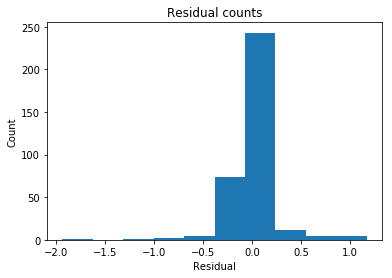

In [43]:
# Extract predicted values.
predicted = regr.predict(X2).ravel().reshape(len(predicted), 1)
actual = Y

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

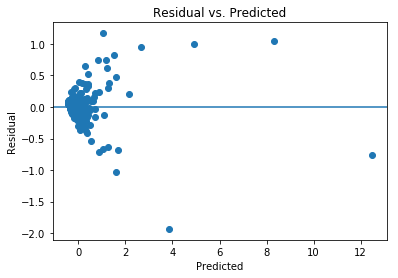

In [44]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

Well, it didn't really change the output. But on the other hand, reducing our analysis to two principle components only reduced R^2 from .95 to .94. 